# CBIR

**Content-based Image Retrieval (CBIR)** is really just a fancy academic word for image search engines.

Image search engines are similar to text search engines, only instead of presenting the search engine with a text query, you instead provide an image query — the image search engine then finds all visually similar/relevant images in its database and returns them to you (just as a text search engine would return links to articles, blog posts, etc.).

Deep learning-based CBIR and image retrieval can be framed as a form of unsupervised learning:

- When training the autoencoder, **we do not use any class labels**

- The autoencoder is then **used to compute the latent-space vector representation for each image in our dataset** (i.e., our “feature vector” for a given image)

- Then, at search time, **we compute the distance between the latent-space vectors** — the smaller the distance, the more relevant/visually similar two images are


We can thus break up the CBIR project into three distinct phases:

**Phase #1: Train the autoencoder**

**Phase #2: Extract features from all images in our dataset by computing their latent-space representations using the autoencoder**

**Phase #3: Compare latent-space vectors to find all relevant images in the dataset**

### Train CBIR autoencoder

In [47]:
from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
#-Other
from imutils import build_montages
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [9]:
def visualize_predictions(decoded, gt, samples=10):
    #initialize our list of output images
    outputs = None

    for i in range(0, samples):
        original = (gt[i]*255).astype("uint8")
        recon = (decoded[i]*255).astype("uint8")

        output = np.hstack([original, recon])

        if outputs is None:
            outputs = output

        else:
            outputs = np.vstack([outputs, output])
    
    return outputs

In [10]:
((trainX, _), (testX, _)) = mnist.load_data()

In [11]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [12]:
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(learning_rate=1e-3, decay=1e-3 / 20)
autoencoder.compile(loss="mse", optimizer=opt)

In [13]:
H = autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=20,
                    batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0190 - val_loss: 0.0110
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/20
1875/1875 [==============================] - 10s 6ms/step - l

In [14]:
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
#cv2.imwrite("output.png", vis)

313/313 [==============================] - 1s 2ms/step


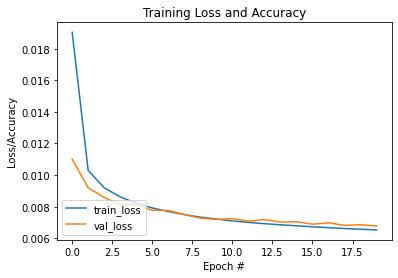

In [15]:
N = np.arange(0, 20)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [16]:
#autoencoder.save("cbir_autoenc" save_format="h5")

### Index Images

In [20]:
autoencoder = load_model('/media/juan/juan1/pyimage_univ/Autoencoders/cbir/output/autoencoder.h5')

In [21]:
#Create the **encoder** model which consists of portion of the autoencoder
encoder = Model(inputs=autoencoder.input, 
outputs=autoencoder.get_layer("encoded").output)#remember to add .input and .output to get the layers

In [22]:
#Quantify the contents of our inputs images with the enconder
features = encoder.predict(trainX)

1875/1875 [==============================] - 3s 1ms/step


In [23]:
# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, trainX.shape[0]))
data = {"indexes":indexes, "features": features}

In [37]:
# write the data dictionary to disk
f = open("/outputs/index.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

### Search images

In [43]:
index = pickle.loads(open('output/index.pickle', "rb").read())

In [39]:
def eucledian(a,b):
    #computer and return the eucleadian distance between two vectors
    return np.linalg.norm(a-b)

In [45]:
def perform_search(queryFeatures, index, maxResults=64):
    #list of results
    results=[]

    for i in range(0, len(data["indexes"])):
    # compute the euclidean distance between our query features
	# and the features for the current image in our index
        d = eucledian(queryFeatures, data["features"][i])
        results.append((d,i))
    
    #sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    return results


In [48]:
# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10,
	replace=False)

# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=225)
	images = []

	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)

	# display the query image
	query = (testX[i] * 255).astype("uint8")
	cv2.imshow("Query", query)

	montage = build_montages(images, (28, 28), (15, 15))[0]
	cv2.imshow("Results", montage)

	cv2.waitKey(0)

cv2.destroyAllWindows()